# 实验1  手写识别
## 罗瑞2210529  
实验一(4学时--两次实验)题目:基于KNN 的手写数字识别实验条件:给定semeion手写数字数据集，给定kNN分类算法

**实验要求:**

1.初级要求:编程实现KNN 算法给出在不同k值(5，9，13)情况下，kNN算法对手写数字的识别精度(要求采用留一法)；

2.中级要求:与机器学习包或平台(如 weka)中的KNN分类器结果进行对比，性能指标为精度 ACC，其他指标如归一化互信息 NMI、混淆熵 CEN 任选其一(或两者)；

3.高级要求:采用旋转等手段对原始数据进行处理，进行至少两个方向(左上，左下)旋转，采用CNN或其他深度学习方法实现手写体识别。


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, confusion_matrix

## 初级要求实现：knn算法具体实现


经过特定的尝试输出可得知，本题数据集中，
每行为一个样本，前256为特征，对应16*16大小的0-1灰度图片，接着是长度10的独热码对应标签（下图为数据形状）:

In [2]:
    # 导入实验数据集
    mypath = 'semeion.data'
    data = pd.read_csv(mypath, sep=' ')
    data = np.array(data)
    data.shape

(1592, 267)

In [3]:
    data[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0

基于数据集结构进行数据预处理，将其划分为特征和标签，其中由于本目标中需要实现的kNN 本质上是基于距离的分类算法，它通过比较测试样本和训练样本之间的距离来确定测试样本的类别，而预测时返回的是邻居的多数类别，所以在预处理时可以直接把原独热码标签转化为数字0-9。

In [6]:
# 预处理封装
def pre_process(filepath):
    data = pd.read_csv(filepath, sep=' ')
    data = np.array(data)
    # 移除最后一列的nan
    data = data[:, :-1]  # 去掉最后nan

    # 分离特征和标签
    X = data[:, :256]  # 前256列是特征
    Y = data[:, 256:]  # 后10列是one-hot标签

    return X, Y

定义knn实际执行算法函数my_knn_predict(X_train, y_train, X_test, k)，使用k近邻的算法，即返回与训练集中距离最近的k个样本对应的标签的最众项：

In [5]:
# 自定义的欧氏距离计算函数
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))
    
# 我的自定义的 kNN 模型
def my_knn_predict(X_train, y_train, X_test, k=3):
    predictions = []
    for test_sample in X_test:
        # 计算测试样本和所有训练样本的距离
        distances = [euclidean_distance(test_sample, train_sample) for train_sample in X_train]

        # 获取最近的 k 个样本的索引
        k_indices = np.argsort(distances)[:k]

        # 获取这 k 个样本的标签
        k_nearest_labels = [y_train[i] for i in k_indices]

        # 多数投票，选择出现最多的标签作为预测结果
        most_common = Counter(k_nearest_labels).most_common(1)
        predictions.append(most_common[0][0])

    return predictions

封装函数call_my_knn(X, y, k)，使得能够在留一法的数据划分基础上调用knn函数：

In [13]:
def call_my_knn(X, y, k):
    # 预测列表和标签列表
    predictions = []
    true_labels = []

    for i in range(X.shape[0]):
        # 留一法：选择当前样本为测试集，其他样本为训练集
        X_loo = np.delete(X, i, axis=0)
        y_loo = np.delete(y, i, axis=0)

        # 当前样本为测试集
        # 注意kNN的输入需要一个二维数组，X[i]是一个形状为 (256,) 的一维向量
        # 需要将其reshape为批数为1的二维数组
        # reshape(1, -1)是对X[i]的重塑操作
        # 1表示将这个样本作为一个批次的数据
        # -1表示自动计算剩余的维度

        X_test_loo = X[i].reshape(1, -1)
        y_test_loo = y[i]

        # 调用自定义 kNN 模型
        y_pred_loo = my_knn_predict(X_loo, y_loo, X_test_loo, k=k)

        # 记录预测结果
        predictions.append(y_pred_loo[0])
        true_labels.append(y_test_loo)

    # 计算准确率，nmi,cen
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

最后，封装指定k值下输出精度的函数，并合理调用执行：

In [14]:
# 计算不同 k 值下的精确度并绘图
def print_accuracies(X, y_labels, k_values):
    accuracies = []

    for k in k_values:
        accuracy = call_my_knn(X, y_labels, k)
        accuracies.append(accuracy)
        print(f"k = {k}, accuracy = {accuracy}")


if __name__ == '__main__':
    # 导入实验数据集
    mypath = 'semeion.data'
    # 数据预处理，分离样本特征和样本标签，并将标签由独热码转化为数字
    X_flat, y = pre_process(mypath)
    y_labels = np.argmax(y, axis=1)  # 将 one-hot 编码转换为数字标签

    # 测试 k 从 1 到 13 的精确度
    k_values = [5, 9, 13]
    print_accuracies(X_flat, y_labels, k_values)

k = 5, accuracy = 0.9170854271356784
k = 9, accuracy = 0.9208542713567839
k = 13, accuracy = 0.9170854271356784


上面输出就是在不同k值(5，9，13)情况下，得出kNN算法对手写数字的识别精度

## 中级要求实现：调用机器学习包的knn分类器结果进行对比  

在第一问的基础上，本问题中需要用到NMI(归一化互信息)以及CEN（混淆熵）的值，对于NMI的计算我直接调用sklearn包中的normalized_mutual_info_score方法即可，但对于CEN只提供了转化成矩阵的方法confusion_matrix，我还需要自己实现计算CEN的函数：

In [14]:
# 定义简单的 CEN (混淆熵) 实现
def ConfusionEntropy(cm):
    cen = 0
    total = np.sum(cm)

    for i in range(len(cm)):
        row_sum = np.sum(cm[i])  # 每一行的和
        for j in range(len(cm[i])):
            if cm[i][j] > 0:
                pij = cm[i][j] / total  # 类别 i 被预测为 j 的概率
                rij = cm[i][j] / row_sum  # 类别 i 被正确预测的概率
                cen += pij * (1 - rij)  # 混乱度

    return cen

这样以来，我就可以计算NMI和CEN了，方式如下：

In [ ]:
nmi = normalized_mutual_info_score(true_labels, predictions)
cen = ConfusionEntropy(confusion_matrix(true_labels, predictions))

另外在第一问的基础上，我还需要调用sklearn中的knn分类器（方法是KNeighborsClassifier）：

In [16]:
def call_ML_package_knn(X, y, k=3):
    # kNN 参数设置
    knn = KNeighborsClassifier(n_neighbors=k)

    # 预测列表和标签列表
    predictions = []
    true_labels = []

    for i in range(X.shape[0]):
        # 留一法：选择当前样本为测试集，其他样本为训练集
        X_loo = np.delete(X, i, axis=0)
        y_loo = np.delete(y, i, axis=0)

        # 当前样本为测试集
        X_test_loo = X[i].reshape(1, -1)
        y_test_loo = y[i]

        # 训练 kNN 模型
        knn.fit(X_loo, y_loo)
        # 预测
        y_pred = knn.predict(X_test_loo)

        # 记录预测结果
        predictions.append(y_pred[0])
        true_labels.append(y_test_loo)

    # 计算准确率，nmi,cen
    accuracy = accuracy_score(true_labels, predictions)
    nmi = normalized_mutual_info_score(true_labels, predictions)
    cen = ConfusionEntropy(confusion_matrix(true_labels, predictions))
    return accuracy, nmi, cen

重新定义call_my_knn函数，增加nmi和cen指标：

In [18]:
def call_my_knn(X, y, k):
    # 预测列表和标签列表
    predictions = []
    true_labels = []

    for i in range(X.shape[0]):
        # 留一法：选择当前样本为测试集，其他样本为训练集
        X_loo = np.delete(X, i, axis=0)
        y_loo = np.delete(y, i, axis=0)

        # 当前样本为测试集
        # 注意kNN的输入需要一个二维数组，X[i]是一个形状为 (256,) 的一维向量
        # 需要将其reshape为批数为1的二维数组
        # reshape(1, -1)是对X[i]的重塑操作
        # 1表示将这个样本作为一个批次的数据
        # -1表示自动计算剩余的维度

        X_test_loo = X[i].reshape(1, -1)
        y_test_loo = y[i]

        # 调用自定义 kNN 模型
        y_pred_loo = my_knn_predict(X_loo, y_loo, X_test_loo, k=k)

        # 记录预测结果
        predictions.append(y_pred_loo[0])
        true_labels.append(y_test_loo)

    # 计算准确率，nmi,cen
    accuracy = accuracy_score(true_labels, predictions)
    nmi = normalized_mutual_info_score(true_labels, predictions)
    cen = ConfusionEntropy(confusion_matrix(true_labels, predictions))
    return accuracy, nmi, cen


为了便于对比，将三种指标（accuracy,nmi,cen）随着不同k值的两种方法对比结果可视化：

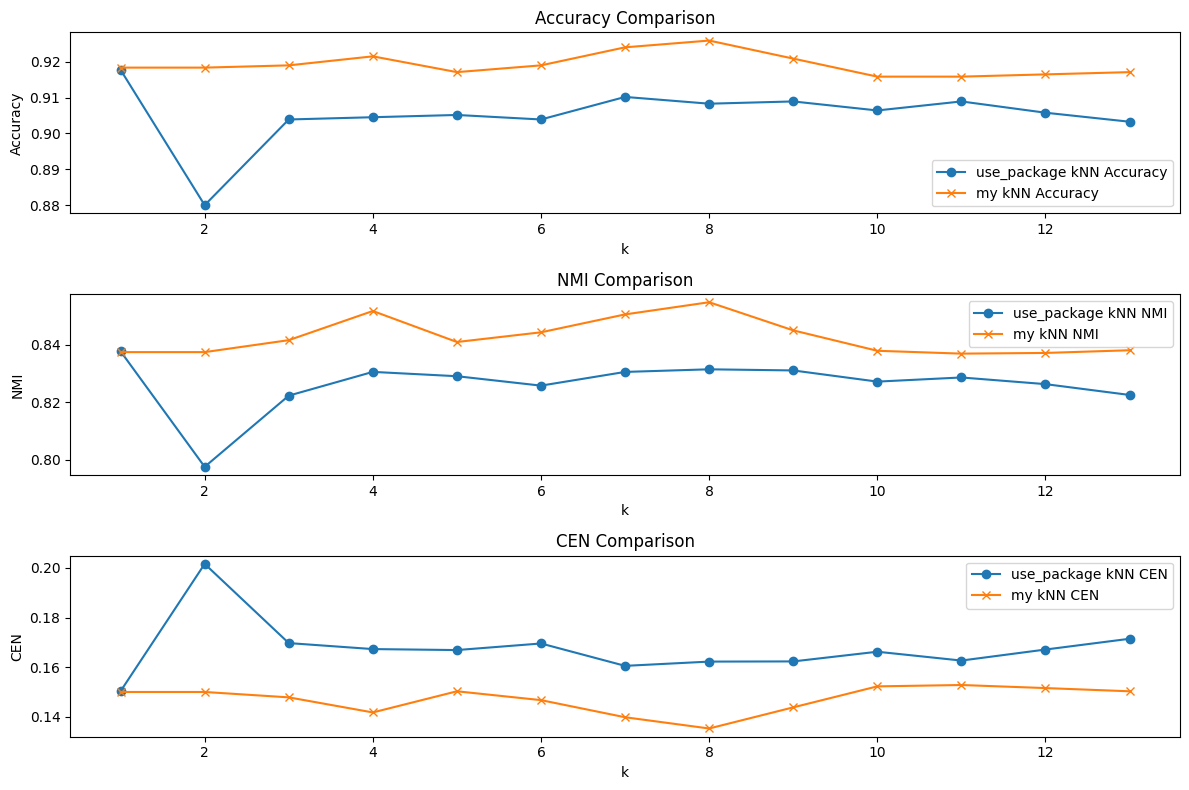

In [19]:
# 绘制 Accuracy, NMI 和 CEN 比较
def plot_knn_comparison(X, y, k_values):
    accuracies_ml = []
    accuracies_custom = []
    nmis_ml = []
    nmis_custom = []
    cen_ml = []
    cen_custom = []

    for k in k_values:
        # 调用机器学习包的 kNN 模型
        ac1, nmi1, cen1 = call_ML_package_knn(X, y, k)
        accuracies_ml.append(ac1)
        nmis_ml.append(nmi1)
        cen_ml.append(cen1)

        # 调用自定义的 kNN 模型
        ac2, nmi2, cen2 = call_my_knn(X, y, k)
        accuracies_custom.append(ac2)
        nmis_custom.append(nmi2)
        cen_custom.append(cen2)

    # 绘制 Accuracy 对比图
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(k_values, accuracies_ml, label='use_package kNN Accuracy', marker='o')
    plt.plot(k_values, accuracies_custom, label='my kNN Accuracy', marker='x')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.legend()

    # 绘制 NMI 对比图
    plt.subplot(3, 1, 2)
    plt.plot(k_values, nmis_ml, label='use_package kNN NMI', marker='o')
    plt.plot(k_values, nmis_custom, label='my kNN NMI', marker='x')
    plt.xlabel('k')
    plt.ylabel('NMI')
    plt.title('NMI Comparison')
    plt.legend()

    # 绘制 CEN 对比图
    plt.subplot(3, 1, 3)
    plt.plot(k_values, cen_ml, label='use_package kNN CEN', marker='o')
    plt.plot(k_values, cen_custom, label='my kNN CEN', marker='x')
    plt.xlabel('k')
    plt.ylabel('CEN')
    plt.title('CEN Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # 导入实验数据集
    mypath = 'semeion.data'
    # 数据预处理，分离样本特征和样本标签，并将标签由独热码转化为数字
    X_flat, y = pre_process(mypath)
    y_labels = np.argmax(y, axis=1)  # 将 one-hot 编码转换为数字标签

    k_values = range(1, 14)  # 测试 k 从 1 到 13

    # 运行绘图函数
    plot_knn_comparison(X_flat, y_labels, k_values)

在评价之前，需要清楚NMI是一种用于测量两个聚类结果之间的相似性的指标的取值范围为0到1，值越高表示聚类结果与真实标签越相似，也说明模型分类效果越好；CEN是受香农熵启发的一种度量，CEN值越小，预测的集成分类效果就越好。


可以发现，在展示范围里的所有k值下，我自己实现的knn相较于sklearn库中实现的knn,总是表现出较高的accuracy，较高的NMI和较低的CEN，说明我的knn优于库函数knn。

## 高级要求实现：采用进行两个方向(左上，左下)旋转手段对原始数据进行处理，采用CNN方法实现手写体识别。

### 1. 旋转处理使得数据集增强

让每个样本对应的图片都进行左上旋转和左下旋转，具体方案是分别顺时针和逆时针围绕图片中心旋转90度：

In [4]:
# 图片左上旋转左下旋转，进行数据增强
def get_reinforce_data(input_x, input_y, n):
    X_plus = []
    Y_plus = []

    for k in range(input_x.shape[0]):
        # 初始化旋转矩阵
        rotated_matrix = np.zeros((n, n), dtype=input_x.dtype)
        # 手动进行左上90度旋转 (顺时针)
        for i in range(n):
            for j in range(n):
                rotated_matrix[j][n - 1 - i] = input_x[k][i][j]
        X_plus.append(np.copy(rotated_matrix))  # 追加矩阵的副本
        # 在这个操作中，X_plus实际上包含的是同一个rotated_matrix
        # 的不同引用（它们指向同一个对象）。所以，为了避免后面的旋转覆盖之前的旋转结果
        # 故使用深拷贝

        Y_plus.append(input_y[k])

        # 手动进行左下90度旋转 (逆时针)
        for i in range(n):
            for j in range(n):
                rotated_matrix[n - 1 - j][i] = input_x[k][i][j]
        X_plus.append(rotated_matrix)  # 追加矩阵的副本
        Y_plus.append(input_y[k])

    return np.array(X_plus), np.array(Y_plus)

在主函数中，我调用此函数来得到一个数据增强后的数据集,后续实现CNN操作时只需直接使用X_pro和Y_pro即可。

In [9]:
# 导入实验数据集
mypath = 'semeion.data'
# 数据预处理，分离样本特征和样本标签，并将标签由独热码转化为数字
X_flat, Y = pre_process(mypath)
X = X_flat.reshape(-1, 16, 16)
# 通过旋转进行数据增强，得到新样本和标签对应的向量
X_p, Y_p = get_reinforce_data(X, Y, 16)

# 将原始数据与增强数据合并
X_pro = np.concatenate((X, X_p), axis=0)  # 按样本（行）合并
Y_pro = np.concatenate((Y, Y_p), axis=0)  # 按样本（行）合并

现在选定一个样本(i=100)进行旋转效果展示（原图片以及旋转后得到的两张图片）

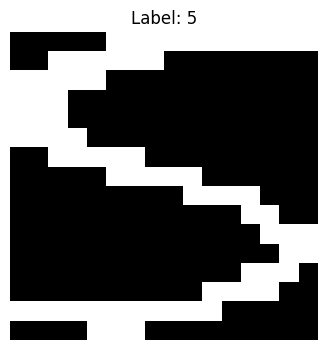

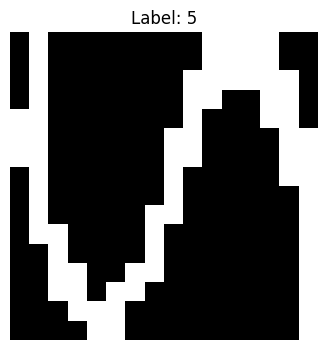

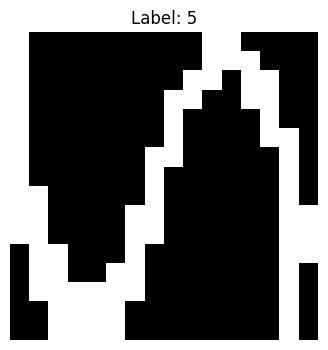

In [27]:
def plot_one(X, y, num_index):
    plt.figure(figsize=(4, 4))  # 调整为合适的图像大小
    plt.imshow(X[num_index].reshape(16, 16), cmap='gray')  # 展示16x16的图像
    plt.title(f"Label: {np.argmax(y[num_index])}")  # 标签为one-hot编码的最大值索引
    plt.axis('off')  # 关闭坐标轴
    plt.show()

plot_one(X,y,100)
plot_one(X_p,Y_p,200)
plot_one(X_p,Y_p,201)

### 2.基于pytorch实现CNN模型类

In [3]:
!pip install torch

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [12]:
# 使用pytorch实现CNN图片识别
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

基于pytorch.nn提供的一系列方法，我定义了一个比较复杂的卷积过程，从而获得较好的效果。具体为三层卷积、三层池化，五层激活函数，三层全连接，即每轮前向传播中，输入x依次经过三轮卷积、池化、激活，再经过三轮的全连接、激活，最后再经历一层全连接，保证最终的输出是长度为10的向量，对应每一种预测标签种类的概率。

In [2]:
# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 定义三个卷积层
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        
        # 定义池化层（2*2像素合为1个像素）
        self.pool = nn.MaxPool2d(2, 2)  

        # 定义全连接层
        self.fc1 = nn.Linear(128 * 2 * 2, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  

        # 定义激活函数Relu
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # 经过三轮卷积、池化、激活
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))  

        x = x.view(-1, 128 * 2 * 2)  

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        return self.fc3(x)

对于本CNN模型，我对数据集划分为训练集：测试集为9：1随机抽取来进行训练和测试。

需要规定好输入的形状：

X_train_tensor: 输入到 CNN 模型时，形状为 (batch_size, 1, 16, 16)，表示 batch_size 个样本，每个样本 1 个通道，大小为 16x16。

y_train_tensor: 标签形状为 (batch_size)，其中每个标签是一个整数类别索引。

X_test_tensor: 测试时，输入的单个样本形状为 (1, 1, 16, 16)，表示 1 个样本、1 个通道、大小为 16x16。

以及调用CNN类进行迭代更新CNN模型并打印每一轮拟合与预测效果的函数完整代码：


In [18]:
# 训练和评估函数
def train_cnn(X, Y, epochs=10, batch_size=64, val_split=0.2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 划分训练集和验证集
    dataset_size = X.shape[0]
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)  # 增加通道层
    Y_tensor = torch.tensor(np.argmax(Y, axis=1), dtype=torch.long).to(device)  # 将数据集中的标签的独热码转化成简单的标签

    # 生成能输入CNN的tensor类型的数据集
    dataset = TensorDataset(X_tensor, Y_tensor)
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 初始化模型
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    # 开始训练
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # 训练阶段
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 验证阶段
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                preds = torch.argmax(output, dim=1).cpu().numpy()
                labels = target.cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)

        # 计算评估指标
        acc = accuracy_score(all_labels, all_preds)
        nmi = normalized_mutual_info_score(all_labels, all_preds)
        cen = ConfusionEntropy(confusion_matrix(all_labels, all_preds))

        # 打印结果
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Loss: {running_loss / len(train_loader):.4f}, Accuracy: {acc:.4f}, NMI: {nmi:.4f}, CEN: {cen:.4f}")

    torch.save(model, './LeNet.pkl')
    
    # 训练并评估CNN模型
train_cnn(X_pro, Y_pro, epochs=50, val_split=0.1)

Epoch 1/50
Loss: 1.8394, Accuracy: 0.4675, NMI: 0.4637, CEN: 0.4592
Epoch 2/50
Loss: 0.8823, Accuracy: 0.7904, NMI: 0.6997, CEN: 0.3346
Epoch 3/50
Loss: 0.4631, Accuracy: 0.8742, NMI: 0.7941, CEN: 0.2188
Epoch 4/50
Loss: 0.2961, Accuracy: 0.8679, NMI: 0.7973, CEN: 0.2172
Epoch 5/50
Loss: 0.1826, Accuracy: 0.9266, NMI: 0.8654, CEN: 0.1351
Epoch 6/50
Loss: 0.1073, Accuracy: 0.9287, NMI: 0.8753, CEN: 0.1288
Epoch 7/50
Loss: 0.0975, Accuracy: 0.9308, NMI: 0.8734, CEN: 0.1264
Epoch 8/50
Loss: 0.0434, Accuracy: 0.9182, NMI: 0.8611, CEN: 0.1436
Epoch 9/50
Loss: 0.0377, Accuracy: 0.9224, NMI: 0.8598, CEN: 0.1418
Epoch 10/50
Loss: 0.0202, Accuracy: 0.9182, NMI: 0.8502, CEN: 0.1491
Epoch 11/50
Loss: 0.0287, Accuracy: 0.9434, NMI: 0.8900, CEN: 0.1067
Epoch 12/50
Loss: 0.0381, Accuracy: 0.9350, NMI: 0.8796, CEN: 0.1212
Epoch 13/50
Loss: 0.0150, Accuracy: 0.9308, NMI: 0.8728, CEN: 0.1273
Epoch 14/50
Loss: 0.0208, Accuracy: 0.9392, NMI: 0.8798, CEN: 0.1147
Epoch 15/50
Loss: 0.0132, Accuracy: 0.9476,

In [ ]:
对训练过程的数据进行收集后，可视化展示模型收敛过程如下：

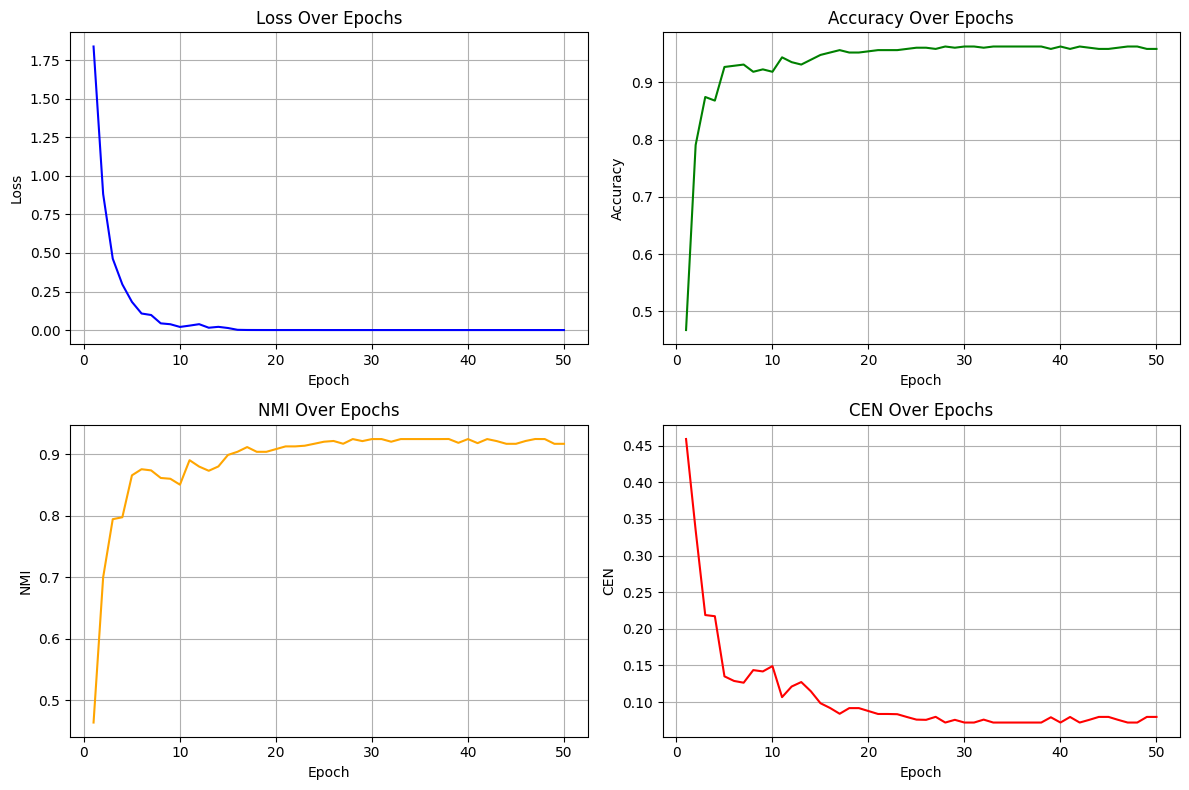

In [19]:
import matplotlib.pyplot as plt

# 数据
epochs = list(range(1, 51))
loss = [1.8394, 0.8823, 0.4631, 0.2961, 0.1826, 0.1073, 0.0975, 0.0434, 0.0377, 0.0202, 0.0287, 0.0381, 0.0150, 0.0208, 0.0132, 0.0015, 0.0004, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]
accuracy = [0.4675, 0.7904, 0.8742, 0.8679, 0.9266, 0.9287, 0.9308, 0.9182, 0.9224, 0.9182, 0.9434, 0.9350, 0.9308, 0.9392, 0.9476, 0.9518, 0.9560, 0.9518, 0.9518, 0.9539, 0.9560, 0.9560, 0.9560, 0.9581, 0.9602, 0.9602, 0.9581, 0.9623, 0.9602, 0.9623, 0.9623, 0.9602, 0.9623, 0.9623, 0.9623, 0.9623, 0.9623, 0.9623, 0.9581, 0.9623, 0.9581, 0.9623, 0.9602, 0.9581, 0.9581, 0.9602, 0.9623, 0.9623, 0.9581, 0.9581]
nmi = [0.4637, 0.6997, 0.7941, 0.7973, 0.8654, 0.8753, 0.8734, 0.8611, 0.8598, 0.8502, 0.8900, 0.8796, 0.8728, 0.8798, 0.8985, 0.9037, 0.9113, 0.9036, 0.9036, 0.9080, 0.9124, 0.9124, 0.9135, 0.9167, 0.9200, 0.9212, 0.9167, 0.9243, 0.9210, 0.9243, 0.9243, 0.9200, 0.9243, 0.9243, 0.9243, 0.9243, 0.9243, 0.9244, 0.9182, 0.9243, 0.9177, 0.9243, 0.9210, 0.9166, 0.9166, 0.9212, 0.9244, 0.9243, 0.9166, 0.9166]
cen = [0.4592, 0.3346, 0.2188, 0.2172, 0.1351, 0.1288, 0.1264, 0.1436, 0.1418, 0.1491, 0.1067, 0.1212, 0.1273, 0.1147, 0.0984, 0.0919, 0.0840, 0.0917, 0.0917, 0.0877, 0.0837, 0.0837, 0.0834, 0.0796, 0.0760, 0.0757, 0.0798, 0.0720, 0.0757, 0.0720, 0.0720, 0.0760, 0.0720, 0.0720, 0.0720, 0.0720, 0.0720, 0.0720, 0.0792, 0.0720, 0.0796, 0.0720, 0.0757, 0.0797, 0.0797, 0.0757, 0.0720, 0.0720, 0.0797, 0.0797]

# 绘图
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label="Loss", color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, label="Accuracy", color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, nmi, label="NMI", color='orange')
plt.xlabel('Epoch')
plt.ylabel('NMI')
plt.title('NMI Over Epochs')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, cen, label="CEN", color='red')
plt.xlabel('Epoch')
plt.ylabel('CEN')
plt.title('CEN Over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()


最后五轮的训练指标为：

Epoch 46/50
Loss: 0.0000, Accuracy: 0.9581, NMI: 0.9166, CEN: 0.0797

Epoch 47/50
Loss: 0.0000, Accuracy: 0.9602, NMI: 0.9212, CEN: 0.0757

Epoch 48/50
Loss: 0.0000, Accuracy: 0.9623, NMI: 0.9244, CEN: 0.0720

Epoch 49/50
Loss: 0.0000, Accuracy: 0.9581, NMI: 0.9166, CEN: 0.0797

Epoch 50/50
Loss: 0.0000, Accuracy: 0.9581, NMI: 0.9166, CEN: 0.0797

可见，在训练集：测试集为9：1远低于留一法的前提下，CNN卷积神经网络模型的预测效果远远高于knn。